<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Feature  3600 non-null   float64
 1   Class    3600 non-null   float64
dtypes: float64(2)
memory usage: 56.4 KB
None
           Feature        Class
count  3600.000000  3600.000000
mean      9.118580     0.555556
std       5.747397     0.496973
min      -3.310259     0.000000
25%       3.710522     0.000000
50%       9.091724     1.000000
75%      13.729211     1.000000
max      25.673673     1.000000
     Feature  Class
0   8.903629    1.0
1   9.946774    1.0
2  14.458392    1.0
3   9.664572    1.0
4  14.412270    1.0

Class Counts:
Class
1.0    2000
0.0    1600
Name: count, dtype: int64


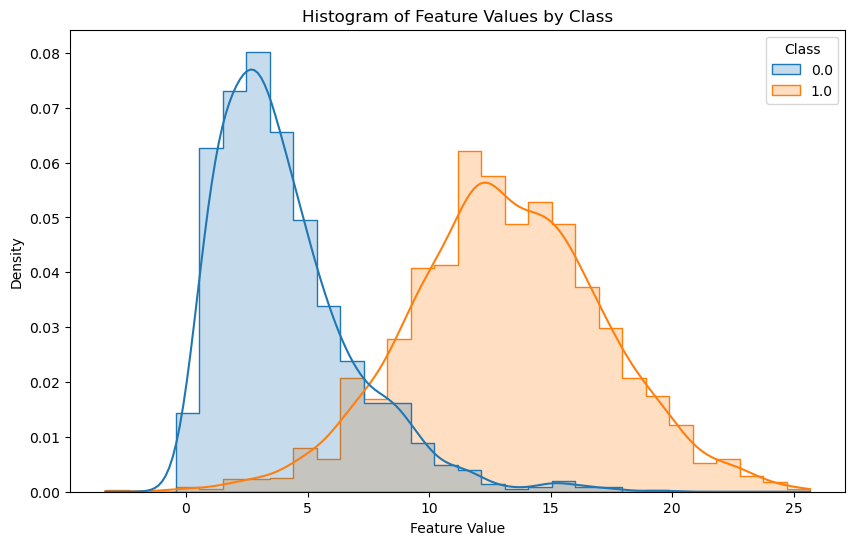


Training Class Distribution:
Class
1.0    0.552778
0.0    0.447222
Name: proportion, dtype: float64

Test Class Distribution:
Class
1.0    0.566667
0.0    0.433333
Name: proportion, dtype: float64
Estimated beta for Class 0 (Gamma): 2.0491408491467307
Estimated mu for Class 1 (Gaussian): 13.137982784521945
Estimated sigma for Class 1 (Gaussian): 4.057052585430489

Class Prior for Class 0: 0.44722222222222224
Class Prior for Class 1: 0.5527777777777778

Test Accuracy: 91.81%

Confusion Matrix:
Predicted    0    1  All
Actual                  
0.0        273   39  312
1.0         20  388  408
All        293  427  720


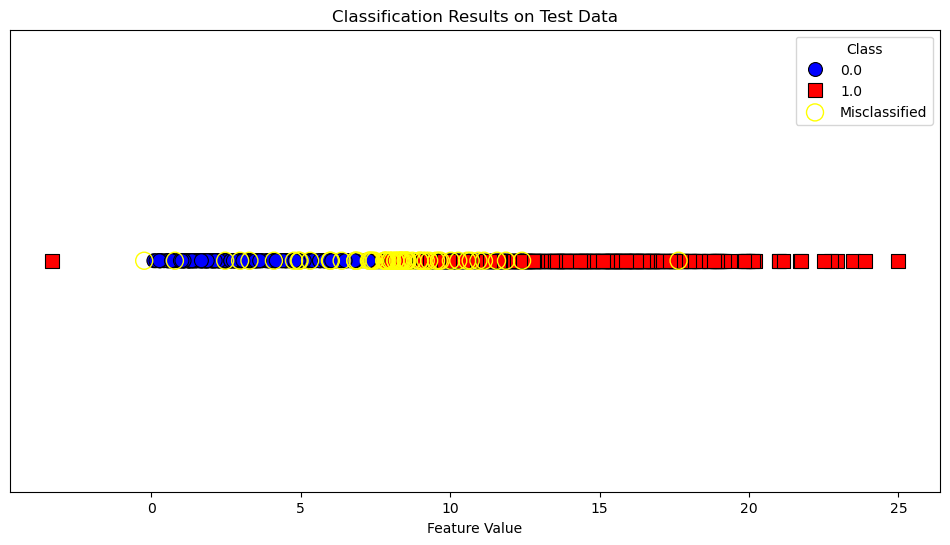

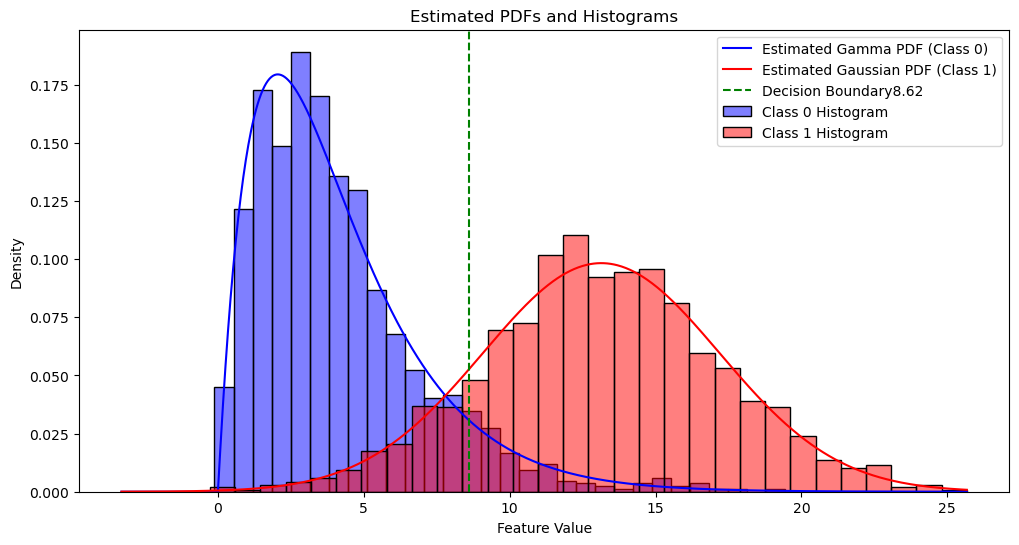

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Explore the Data
data = pd.read_csv('../data/data_problem2.csv',delimiter=',', header=None)
data = data.T.reset_index(drop=True)
data.columns = ['Feature', 'Class']

# General Information
print(data.info())
print(data.describe())
print(data.head())

# Class Counts
class_counts = data['Class'].value_counts()
print("\nClass Counts:")
print(class_counts)

# Features and Labels
X = data['Feature'].values
y = data['Class'].values

# Step 2: Plot Histograms
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Feature', hue='Class', bins=30, kde=True, element='step', stat='density')
plt.title('Histogram of Feature Values by Class')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.show()

# Step 3: Split the Data
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
split_ratio = 0.8
split_index = int(len(data_shuffled) * split_ratio)

train_data = data_shuffled.iloc[:split_index]
X_train = train_data['Feature'].values
y_train = train_data['Class'].values

test_data = data_shuffled.iloc[split_index:]
X_test = test_data['Feature'].values
y_test = test_data['Class'].values

# Class Proportions
print("\nTraining Class Distribution:")
print(train_data['Class'].value_counts(normalize=True))

print("\nTest Class Distribution:")
print(test_data['Class'].value_counts(normalize=True))

# Step 4: Estimate Parameters

# Gamma distribution for Class 0
alpha = 2  # Given shape parameter
X_train_c0 = X_train[y_train == 0]
n0 = len(X_train_c0)
beta_hat = np.mean(X_train_c0) / alpha  # Estimate beta
print(f"Estimated beta for Class 0 (Gamma): {beta_hat}")

# Gaussian distribution for Class 1
X_train_c1 = X_train[y_train == 1]
n1 = len(X_train_c1)
mu_hat = np.mean(X_train_c1)  # Estimate mu
sigma_squared_hat = np.var(X_train_c1, ddof=0)  # Estimate sigma^2
sigma_hat = np.sqrt(sigma_squared_hat)  # Estimate sigma
print(f"Estimated mu for Class 1 (Gaussian): {mu_hat}")
print(f"Estimated sigma for Class 1 (Gaussian): {sigma_hat}")

# Step 5: Define PDFs
def gamma_pdf(x, alpha, beta):
    # Since alpha = 2, Gamma(alpha) = 1
    x = np.maximum(x, 1e-10)  # Ensure x > 0
    coef = 1 / (beta ** alpha)  # Simplified coefficient
    pdf = coef * x ** (alpha - 1) * np.exp(-x / beta)
    return pdf

def gaussian_pdf(x, mu, sigma):
    coef = 1 / (sigma * np.sqrt(2 * np.pi))
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    pdf = coef * np.exp(exponent)
    return pdf


# Step 6: Implement Classifier
prior_c0 = np.mean(y_train == 0)
prior_c1 = np.mean(y_train == 1)
print(f"\nClass Prior for Class 0: {prior_c0}")
print(f"Class Prior for Class 1: {prior_c1}")

# def bayes_classifier(x, alpha, beta, mu, sigma, prior_c0, prior_c1):
#     likelihood_c0 = gamma_pdf(x, alpha, beta)
#     likelihood_c1 = gaussian_pdf(x, mu, sigma)
#     posterior_c0 = likelihood_c0 * prior_c0
#     posterior_c1 = likelihood_c1 * prior_c1
#     predictions = np.where(posterior_c0 > posterior_c1, 0, 1)
#     return predictions
def bayes_classifier(x, alpha, beta, mu, sigma, prior_c0, prior_c1):
    log_likelihood_c0 = np.log(gamma_pdf(x, alpha, beta) + 1e-300)
    log_likelihood_c1 = np.log(gaussian_pdf(x, mu, sigma) + 1e-300)
    log_posterior_c0 = log_likelihood_c0 + np.log(prior_c0)
    log_posterior_c1 = log_likelihood_c1 + np.log(prior_c1)
    predictions = np.where(log_posterior_c0 > log_posterior_c1, 0, 1)
    return predictions

# Step 7: Make Predictions
X_test_reshaped = X_test.reshape(-1, 1)
y_pred = bayes_classifier(X_test_reshaped.ravel(), alpha, beta_hat, mu_hat, sigma_hat, prior_c0, prior_c1)

# Step 8: Evaluate Classifier
accuracy = np.mean(y_pred == y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("\nConfusion Matrix:")
print(confusion_matrix)

# Step 9: Analyze Misclassifications
misclassified_indices = np.where(y_pred != y_test)[0]
misclassified_samples = X_test[misclassified_indices]
correct_indices = np.where(y_pred == y_test)[0]
correct_samples = X_test[correct_indices]
correct_labels = y_test[correct_indices]

plt.figure(figsize=(12, 6))

sns.scatterplot(x=correct_samples, y=np.zeros_like(correct_samples), hue=correct_labels, 
                palette={0: 'blue', 1: 'red'}, style=correct_labels, markers={0: 'o', 1: 's'}, 
                edgecolor='k', s=100, legend='full')

plt.scatter(misclassified_samples, np.zeros_like(misclassified_samples), 
            facecolors='none', edgecolors='yellow', s=150, label='Misclassified')

plt.xlabel('Feature Value')
plt.yticks([])
plt.legend(title='Class', loc='upper right')
plt.title('Classification Results on Test Data')
plt.show()

# Step 10: Additional Visualization
x_values = np.linspace(min(X), max(X), 1000)
gamma_pdf_values = gamma_pdf(x_values, alpha, beta_hat)
gaussian_pdf_values = gaussian_pdf(x_values, mu_hat, sigma_hat)

plt.figure(figsize=(12, 6))

sns.histplot(X_train_c0, bins=30, color='blue', alpha=0.5, stat='density', label='Class 0 Histogram')
sns.histplot(X_train_c1, bins=30, color='red', alpha=0.5, stat='density', label='Class 1 Histogram')

plt.plot(x_values, gamma_pdf_values, color='blue', label='Estimated Gamma PDF (Class 0)')
plt.plot(x_values, gaussian_pdf_values, color='red', label='Estimated Gaussian PDF (Class 1)')
# adding descision boundary
plt.axvline(x=(mu_hat+ beta_hat * alpha)/2, color='green', linestyle='--', label=f'Decision Boundary{(mu_hat+ beta_hat * alpha)/2:.2f}')

plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.legend()
plt.title('Estimated PDFs and Histograms')
plt.show()


In [13]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
print(f"Precision for Class 1: {precision:.2f}")
print(f"Recall for Class 1: {recall:.2f}")
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, pos_label=1)
print(f"F1-Score for Class 1: {f1:.2f}")


Precision for Class 1: 0.92
Recall for Class 1: 0.93
F1-Score for Class 1: 0.92


---
# Loss Surface Visualization

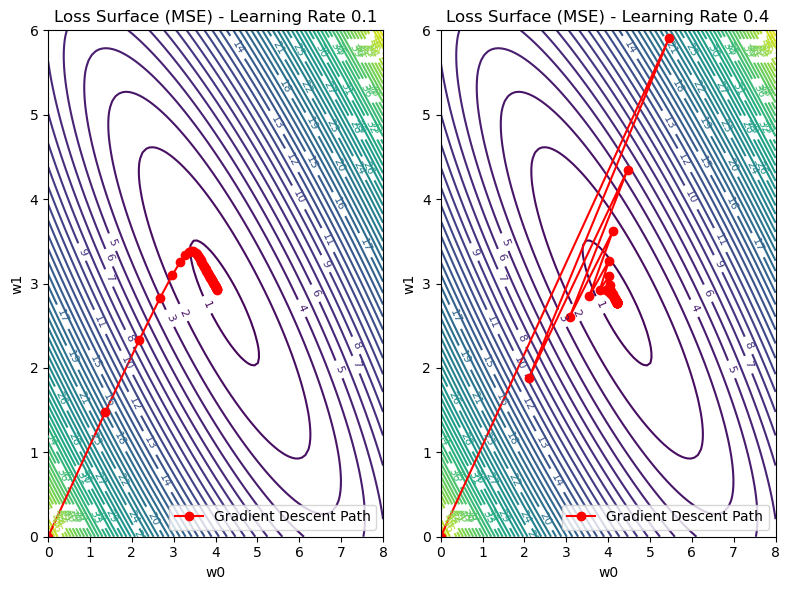

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
N = 100
x = 2 * np.random.rand(N)
y = 4 + 3 * x + np.random.randn(N)

# Define the loss function (MSE)
def mse_loss(w0, w1, x, y):
    y_pred = w0 + w1 * x
    return np.mean((y - y_pred) ** 2)

# Create a grid of weight values
w0_values = np.linspace(0, 8, 100)
w1_values = np.linspace(0, 6, 100)
W0, W1 = np.meshgrid(w0_values, w1_values)
Loss = np.array([[mse_loss(w0, w1, x, y) for w0 in w0_values] for w1 in w1_values])

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Plot the loss surface with learning rate 0.1
CS = axs[0].contour(W0, W1, Loss, levels=50, cmap='viridis')
axs[0].clabel(CS, inline=1, fontsize=8)
axs[0].set_xlabel('w0')
axs[0].set_ylabel('w1')
axs[0].set_title('Loss Surface (MSE) - Learning Rate 0.1')

# Initialize weights
w0, w1 = 0.0, 0.0
learning_rate = 0.1
iterations = 50
w0_history = [w0]
w1_history = [w1]

# Gradient descent loop
for i in range(iterations):
    y_pred = w0 + w1 * x
    error = y_pred - y
    grad_w0 = (2 / N) * np.sum(error)
    grad_w1 = (2 / N) * np.sum(error * x)
    w0 -= learning_rate * grad_w0
    w1 -= learning_rate * grad_w1
    w0_history.append(w0)
    w1_history.append(w1)

# Plot the trajectory
axs[0].plot(w0_history, w1_history, 'ro-', label='Gradient Descent Path')
axs[0].legend()

# Plot the loss surface with learning rate 0.4
CS = axs[1].contour(W0, W1, Loss, levels=50, cmap='viridis')
axs[1].clabel(CS, inline=1, fontsize=8)
axs[1].set_xlabel('w0')
axs[1].set_ylabel('w1')
axs[1].set_title('Loss Surface (MSE) - Learning Rate 0.4')

# Initialize weights
w0, w1 = 0.0, 0.0
learning_rate = 0.4
iterations = 50
w0_history = [w0]
w1_history = [w1]

# Gradient descent loop
for i in range(iterations):
    y_pred = w0 + w1 * x
    error = y_pred - y
    grad_w0 = (2 / N) * np.sum(error)
    grad_w1 = (2 / N) * np.sum(error * x)
    w0 -= learning_rate * grad_w0
    w1 -= learning_rate * grad_w1
    w0_history.append(w0)
    w1_history.append(w1)

# Plot the trajectory
axs[1].plot(w0_history, w1_history, 'ro-', label='Gradient Descent Path')
axs[1].legend()

plt.tight_layout()
plt.show()

----
# Sklearn version

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Feature  3600 non-null   float64
 1   Class    3600 non-null   float64
dtypes: float64(2)
memory usage: 56.4 KB
None
           Feature        Class
count  3600.000000  3600.000000
mean      9.118580     0.555556
std       5.747397     0.496973
min      -3.310259     0.000000
25%       3.710522     0.000000
50%       9.091724     1.000000
75%      13.729211     1.000000
max      25.673673     1.000000


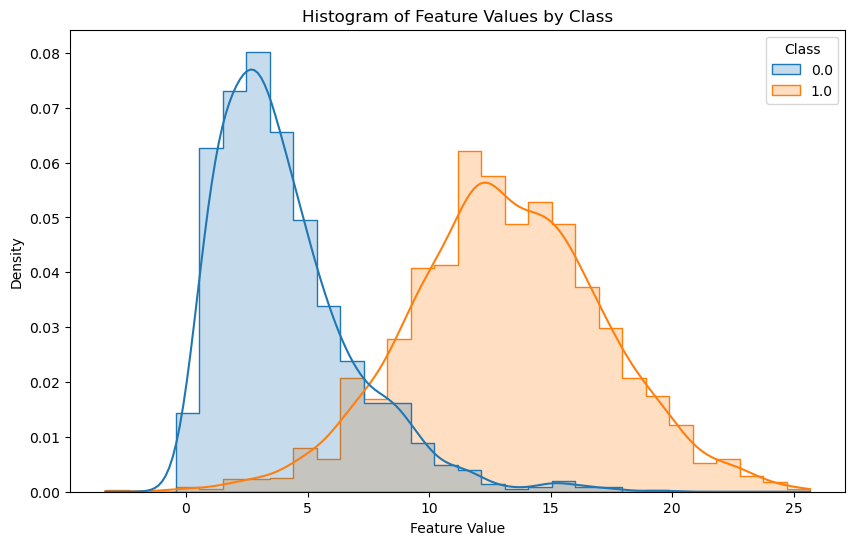

Estimated beta for Class 0 (Gamma): 2.032329063496918
Estimated mu for Class 1 (Gaussian): 13.134140796756627
Estimated sigma for Class 1 (Gaussian): 4.000040019724593
Class Prior for Class 0: 0.44479166666666664
Class Prior for Class 1: 0.5552083333333333
Test Accuracy: 91.53%
Confusion Matrix:
[[286  33]
 [ 28 373]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       319
         1.0       0.92      0.93      0.92       401

    accuracy                           0.92       720
   macro avg       0.91      0.91      0.91       720
weighted avg       0.92      0.92      0.92       720



In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and explore the data
data = pd.read_csv('../data/data_problem2.csv', header=None)
data = data.T.reset_index(drop=True)
data.columns = ['Feature', 'Class']
print(data.info())  # General information about the dataset
print(data.describe())  # Summary statistics

# Step 2: Visualize data
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Feature', hue='Class', kde=True, bins=30, element='step', stat='density')
plt.title('Histogram of Feature Values by Class')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.show()
# Step 1: Split the data into training and test sets
X = data['Feature'].values
y = data['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: MLE for the Gamma (Class 0) and Gaussian (Class 1) distributions
# MLE for Class 0 (Gamma) with known alpha=2
alpha = 2
X_train_c0 = X_train[y_train == 0]  # Samples from Class 0 (Gamma)
n0 = len(X_train_c0)
beta_hat = np.mean(X_train_c0) / alpha  # MLE for beta
print(f'Estimated beta for Class 0 (Gamma): {beta_hat}')

# MLE for Class 1 (Gaussian)
X_train_c1 = X_train[y_train == 1]  # Samples from Class 1 (Gaussian)
n1 = len(X_train_c1)
mu_hat = np.mean(X_train_c1)  # MLE for mu
sigma_hat = np.std(X_train_c1)  # MLE for sigma
print(f'Estimated mu for Class 1 (Gaussian): {mu_hat}')
print(f'Estimated sigma for Class 1 (Gaussian): {sigma_hat}')

# Step 3: Define PDFs for the Gamma and Gaussian distributions
def gamma_pdf(x, alpha, beta):
    x = np.maximum(x, 1e-10)  # Ensure no negative values for x
    coef = (1 / (beta**alpha))  # Simplified for alpha = 2, so Γ(2) = 1
    return coef * x**(alpha - 1) * np.exp(-x / beta)

def gaussian_pdf(x, mu, sigma):
    coef = 1 / (sigma * np.sqrt(2 * np.pi))
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    return coef * np.exp(exponent)

# Step 4: Implement the Bayes Classifier
def bayes_classifier(x, alpha, beta, mu, sigma, prior_c0, prior_c1):
    likelihood_c0 = gamma_pdf(x, alpha, beta)
    likelihood_c1 = gaussian_pdf(x, mu, sigma)
    posterior_c0 = likelihood_c0 * prior_c0
    posterior_c1 = likelihood_c1 * prior_c1
    return np.where(posterior_c0 > posterior_c1, 0, 1)

# Calculate class priors
prior_c0 = np.mean(y_train == 0)
prior_c1 = np.mean(y_train == 1)
print(f'Class Prior for Class 0: {prior_c0}')
print(f'Class Prior for Class 1: {prior_c1}')

# Step 5: Make predictions on the test set
y_pred = bayes_classifier(X_test, alpha, beta_hat, mu_hat, sigma_hat, prior_c0, prior_c1)

# Step 6: Evaluate the classifier performance
accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(classification_report(y_test, y_pred))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Feature  3600 non-null   float64
 1   Class    3600 non-null   float64
dtypes: float64(2)
memory usage: 56.4 KB
None
           Feature        Class
count  3600.000000  3600.000000
mean      9.118580     0.555556
std       5.747397     0.496973
min      -3.310259     0.000000
25%       3.710522     0.000000
50%       9.091724     1.000000
75%      13.729211     1.000000
max      25.673673     1.000000


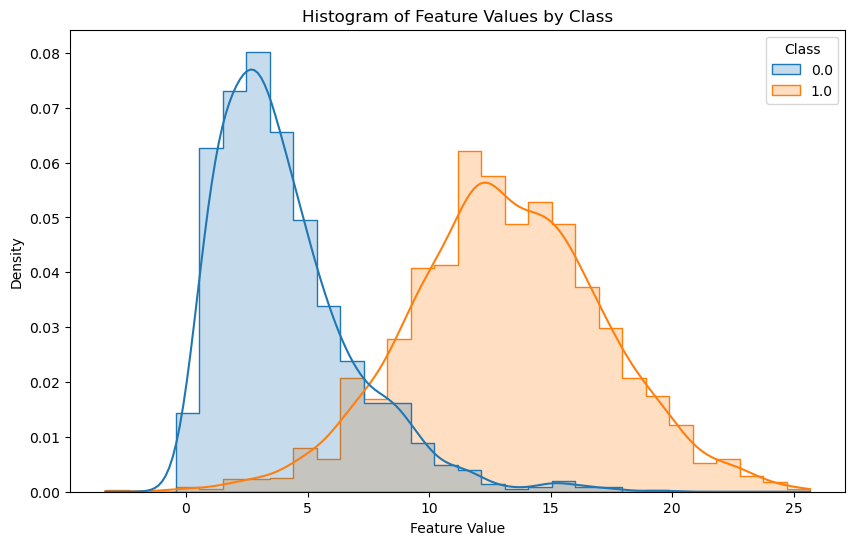

Estimated beta for Class 0 (Gamma): -0.4401004670189094
Estimated mu for Class 1 (Gaussian): 0.7051515925593782
Estimated sigma for Class 1 (Gaussian): 0.6992100633151267
Class Prior for Class 0: 0.44479166666666664
Class Prior for Class 1: 0.5552083333333333
Test Accuracy: 50.06%
Confusion Matrix:
[[ 16 303]
 [340  61]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.04      0.05      0.05       319
         1.0       0.17      0.15      0.16       401

    accuracy                           0.11       720
   macro avg       0.11      0.10      0.10       720
weighted avg       0.11      0.11      0.11       720



TypeError: '>' not supported between instances of 'float' and 'NoneType'

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Step 1: Load and explore the data
data = pd.read_csv('../data/data_problem2.csv', header=None)
data = data.T.reset_index(drop=True)
data.columns = ['Feature', 'Class']
print(data.info())  # General information about the dataset
print(data.describe())  # Summary statistics

# Step 2: Visualize data
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Feature', hue='Class', kde=True, bins=30, element='step', stat='density')
plt.title('Histogram of Feature Values by Class')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.show()

# Step 3: Split the data into training and test sets
X = data['Feature'].values
y = data['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature to ensure better performance (log transform or StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1))
X_test_scaled = scaler.transform(X_test.reshape(-1, 1))

# Step 4: MLE for the Gamma (Class 0) and Gaussian (Class 1) distributions
alpha = 2  # Assumed alpha for Gamma distribution
X_train_c0 = X_train_scaled[y_train == 0]  # Samples from Class 0 (Gamma)
n0 = len(X_train_c0)
beta_hat = np.mean(X_train_c0) / alpha  # MLE for beta
print(f'Estimated beta for Class 0 (Gamma): {beta_hat}')

X_train_c1 = X_train_scaled[y_train == 1]  # Samples from Class 1 (Gaussian)
n1 = len(X_train_c1)
mu_hat = np.mean(X_train_c1)  # MLE for mu
sigma_hat = np.std(X_train_c1)  # MLE for sigma
print(f'Estimated mu for Class 1 (Gaussian): {mu_hat}')
print(f'Estimated sigma for Class 1 (Gaussian): {sigma_hat}')

# Step 5: Define PDFs for Gamma and Gaussian distributions
def gamma_pdf(x, alpha, beta):
    x = np.maximum(x, 1e-10)  # Avoid negative values
    coef = (1 / (beta**alpha))
    return coef * x**(alpha - 1) * np.exp(-x / beta)

def gaussian_pdf(x, mu, sigma):
    coef = 1 / (sigma * np.sqrt(2 * np.pi))
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    return coef * np.exp(exponent)

# Step 6: Implement the Bayes Classifier with thresholding
def bayes_classifier(x, alpha, beta, mu, sigma, prior_c0, prior_c1, threshold=0.5):
    likelihood_c0 = gamma_pdf(x, alpha, beta)
    likelihood_c1 = gaussian_pdf(x, mu, sigma)
    posterior_c0 = likelihood_c0 * prior_c0
    posterior_c1 = likelihood_c1 * prior_c1
    posterior_ratio = posterior_c0 / (posterior_c0 + posterior_c1)
    return np.where(posterior_ratio > threshold, 0, 1)

# Calculate class priors
prior_c0 = np.mean(y_train == 0)
prior_c1 = np.mean(y_train == 1)
print(f'Class Prior for Class 0: {prior_c0}')
print(f'Class Prior for Class 1: {prior_c1}')

# Step 7: Make predictions with thresholding on test set
threshold = 0.4  # Lower threshold to handle class imbalance
y_pred = bayes_classifier(X_test_scaled, alpha, beta_hat, mu_hat, sigma_hat, prior_c0, prior_c1, threshold)

# Step 8: Evaluate the classifier performance
accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Step 9: ROC Curve
fpr, tpr, _ = roc_curve(y_test, bayes_classifier(X_test_scaled, alpha, beta_hat, mu_hat, sigma_hat, prior_c0, prior_c1, threshold=None))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
